In [57]:
import numpy as np 
import matplotlib.pyplot as plt   

def load_sample_dataset():
    """Load a ndarray sample dataset and an array of labels for testing AdaBoost"""
    dataset = np.array([[1., 2.1], [2., 1.1], [1.3, 1.], [1., 1.], [2., 1.]])
    labels = np.array([1.0, 1.0, -1.0, -1.0, 1.0])
    return dataset, labels

def build_stump(dataset, labels, D):
    """Build a single stump to classify the dataset and calculate the weighted error of the stump.
    
    Args:
        dataset: ndarray of inputs. Shape (m, n)
        labels: array of labels. Shape (m,)
        D: array of weights on each example. Shape (m,)
    Returns:
        stump: a dict containing splitting feature, threshold, inequality
        err: the weighted err of the stump on dataset
        pred: array of predictions on dataset
    """
    m, n = dataset.shape
    
    stump = {}
    err = float('inf')
    pred = np.array(m)

    steps = 10

    # Loop over each feature with a stepsize to find min error sum
    for i in range(n):
        xi_min = dataset[:, i].min()
        xi_max = dataset[:, i].max()
        step_size = (xi_max - xi_min) / steps

        for j in range(-1, steps + 1):
            for inequal in ['lt', 'gt']:
                thresh = xi_min + step_size * j
                pred_i = stump_classify(dataset, i, thresh, inequal)

                err_i = (pred_i != labels).astype(int)
                weighted_err_i = D.dot(err_i)
#                 print('The stump splits on dim: {} with threshold: {}, the weighted error is {}'.format(i, thresh, weighted_err_i))

                if weighted_err_i < err:
                    err = weighted_err_i
                    stump['inequal'] = inequal
                    stump['dim'] = i
                    stump['thresh'] = thresh
                    pred = pred_i
    
    return stump, err, pred

def stump_classify(dataset, dim, thresh, inequal):
    """Classify a dataset based on the stump parameters as inputs.

    Args: 
        dataset: ndarray of inputs. Shape (m, n)
        dim: the feature dimension split on
        thresh: threshold for splitting
        inequal: lt - less than. gt - greater than
    Returns:
        pred: array of predictions on dataset
    """
    pred = np.ones(dataset.shape[0])

    if inequal == 'lt':
        pred[dataset[:, dim] <= thresh] = -1
    else:
        pred[dataset[:, dim] > thresh] = -1

    return pred

def adaboost_train(dataset, labels, max_iter=40):
    """Train an Adaptive Boosting model using stumps on dataset.
    
    Args:
        dataset: ndarray of inputs. Shape (m, n)
        labels: array of labels. Shape (m,)
        max_iter: maximum iterations allowed for learning
    Returns:
        models: a list of stump classifier, each stump contains a weighting parameter alpha
    """
    m, n = dataset.shape
    D = np.ones(m) / m
    models = []
    aggr_pred = np.zeros(m)

    for k in range(max_iter):
        stump_k, err_k, pred_k = build_stump(dataset, labels, D)
        alpha_k = 0.5 * np.log((1 - err_k) / max(err_k, 1e-16))
#         print('Predicted result: ', pred_k)

        expon = np.exp(-alpha_k * labels * pred_k)
        D = (D * expon) / (D.dot(expon))

        stump_k['alpha'] = alpha_k
        models.append(stump_k)

        aggr_pred += alpha_k * pred_k
        aggr_err = (np.sign(aggr_pred) != labels).sum()
        print('Iteration: {}, the error rate is {}'.format(k, aggr_err / m))
        if aggr_err == 0:
            break

    return models, aggr_pred

def adaboost_classify(dataset, models):
    """Classify a dataset given adaboost models.
    
    Args:
        dataset: ndarray of inputs. Shape (m, n)
        models: a list of stump classifier, each stump contains a weighting parameter alpha
    Return:
        pred: array of predicted labels for input dataset
    """
    m = dataset.shape[0]
    pred = np.zeros(m)

    for model in models:
        pred += model['alpha'] * stump_classify(dataset, model['dim'], model['thresh'], model['inequal'])

    return np.sign(pred)

def load_dataset(path):
    """From path load data into a ndarray of x matrix and an array of labels.
    
    Args:
        path: the path to the txt file
    Returns:
        dataset: ndarray containing feature vectors
        labels: array containing labels
    """
    # Load one row to get size 
    with open(path, 'r') as fr:
        first_row = fr.readline().strip().split('\t')
        
    x_cols = [i for i in range(len(first_row) - 1)]
    l_col = [len(first_row) - 1]
    
    dataset = np.loadtxt(path, delimiter='\t', usecols=x_cols)
    labels = np.loadtxt(path, delimiter='\t', usecols=l_col)
    return dataset, labels

def plot_ROC(aggr_pred, labels):
    """Plot the ROC of a model with it's predicted value and labels.
    
    Args:
        aggr_pred: array of the predicted strengths of examples. Shape (m,)
        labels: array of labele. Shape (m,)
    """
    fig, ax = plt.subplots()
    cur_pos = [0.0, 0.0]    # current position
    y_sum = 0

    p_num = (labels == 1).sum() # num of positive labels
    v_stepsize = 1 / p_num      # step size along true positive axis
    
    n_num = labels.shape[0] - p_num    # num of negative labels
    h_stepsize = 1 / n_num      # step size along false positive axis
   
    desc_indices = np.argsort(-aggr_pred)   # get the index of descending prediction strength
    for i in list(desc_indices):
        if labels[i] == 1:
            x = cur_pos[0]
            y = cur_pos[1] + v_stepsize
        else:
            x = cur_pos[0] + h_stepsize
            y = cur_pos[1]
            y_sum += y

        ax.plot([cur_pos[0], x], [cur_pos[1], y], c='b')  # ax.plot([x list], [y list])
        cur_pos = [x, y]
#         print(cur_pos)

    ax.plot([0, 1], [0, 1], 'b--')  # plot the line of random selection
    ax.axis([0, 1, 0, 1])   # ax.axis([xmin, xmax, ymin, ymax])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig('adaboost_horsecolic_roc.png')

    AUC = y_sum * h_stepsize
    print('The Area Under Curve is {}'.format(AUC))

In [44]:
# Test for sample dataset
dataset, labels = load_sample_dataset()
D = np.ones(5) / 5
models, aggr_pred = adaboost_train(dataset, labels)
adaboost_classify(np.array([[1, 2.1]]), models)

Iteration: 0, the error rate is 0.2
Iteration: 1, the error rate is 0.2
Iteration: 2, the error rate is 0.0


array([1.])

In [45]:
# Test for horse colic dataset
x_train, y_train = load_dataset('horseColicTraining2.txt')
x_test, y_test = load_dataset('horseColicTest2.txt')

stumps, aggr_pred = adaboost_train(x_train, y_train)
pred_test = adaboost_classify(x_test, stumps)
err_rate_test = (pred_test != y_test).sum() / x_test.shape[0]
print('Test error rate is {}'.format(err_rate_test))

Iteration: 0, the error rate is 0.2842809364548495
Iteration: 1, the error rate is 0.2842809364548495
Iteration: 2, the error rate is 0.24749163879598662
Iteration: 3, the error rate is 0.24749163879598662
Iteration: 4, the error rate is 0.25418060200668896
Iteration: 5, the error rate is 0.2408026755852843
Iteration: 6, the error rate is 0.2408026755852843
Iteration: 7, the error rate is 0.22073578595317725
Iteration: 8, the error rate is 0.24749163879598662
Iteration: 9, the error rate is 0.23076923076923078
Iteration: 10, the error rate is 0.2408026755852843
Iteration: 11, the error rate is 0.2140468227424749
Iteration: 12, the error rate is 0.22742474916387959
Iteration: 13, the error rate is 0.21739130434782608
Iteration: 14, the error rate is 0.22073578595317725
Iteration: 15, the error rate is 0.21739130434782608
Iteration: 16, the error rate is 0.22408026755852842
Iteration: 17, the error rate is 0.22408026755852842
Iteration: 18, the error rate is 0.23076923076923078
Iteration

The Area Under Curve is 0.8919583991085535


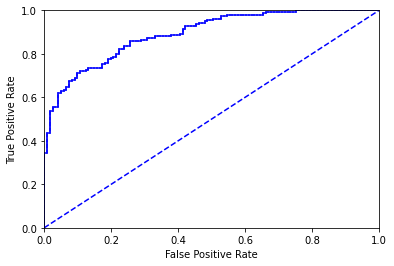

In [58]:
plot_ROC(aggr_pred, y_train)